In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import random 
from keras.layers import LSTM, Dense
from keras.models import Sequential


# 设置plt中文字体以及显示负号
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
def seed_everything(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
SEED = 42 
seed_everything(SEED)

df_year = pd.read_csv('./year.csv')
df_year.index = df_year['year']

# 读取数据
df = pd.read_csv('./2022_APMCM_C_Data.csv', encoding='gbk')

# dt转换为标准的时间序列格式
df.index = pd.DatetimeIndex(df['dt'])
df.drop(columns=['dt'], inplace=True)

# 备份数据
df_copy = df.copy()
df_copy['location'] = df_copy['Country'] + ' ' + df_copy['City']
df_copy.drop(columns=['Country', 'City'], inplace=True)
df_copy['year'] = df_copy.index.strftime('%Y').astype(int)
df_copy['month'] = df_copy.index.strftime('%m').astype(int)
df_copy = df_copy[df_copy.index != '2013-09-01']

Using TensorFlow backend.


# LSTM

In [2]:
TIMESTEP = 16
from sklearn.preprocessing import StandardScaler
df = df_year.copy()[['AverageTemperature', 'year', 'location', 'Latitude', 'Longitude']]
scaler_temperature = StandardScaler()
scaler_year = StandardScaler()
scaler_latitude = StandardScaler()
scaler_longitude = StandardScaler()
df['AverageTemperature'] = scaler_temperature.fit_transform(df[['AverageTemperature']])
df['year'] = scaler_year.fit_transform(df[['year']])
df['Latitude'] = scaler_latitude.fit_transform(df[['Latitude']])
df['Longitude'] = scaler_longitude.fit_transform(df[['Longitude']])
X_train = []
y_train = []
# 创建训练集
for location in df['location'].unique():
    df_1 = df[df['location']==location].copy().drop(columns=['location'])
    X_train1 = []
    y_train1 = []
    X_val1 = []
    y_val1 = []
    for i in range(1900 + TIMESTEP, 2013):
        X_train2 = df_1.loc[i -TIMESTEP: i - 1]
        y_train2 = df_1.loc[i]['AverageTemperature']
        X_train1.append(X_train2)
        y_train1.append(y_train2)
    X_train1 = np.array(X_train1)
    y_train1 = np.array(y_train1)
    X_train.append(X_train1)
    y_train.append(y_train1)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
print(X_train.shape, y_train.shape)


model = Sequential()
model.add(LSTM(16, input_shape=(TIMESTEP, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=64)

(9700, 16, 4) (9700,)
Epoch 1/10
9700/9700 [==============================] - 2s 226us/step - loss: 0.3566
Epoch 2/10
9700/9700 [==============================] - 3s 263us/step - loss: 0.0260
Epoch 3/10
9700/9700 [==============================] - 4s 450us/step - loss: 0.0101
Epoch 4/10
9700/9700 [==============================] - 4s 384us/step - loss: 0.0058
Epoch 5/10
9700/9700 [==============================] - 3s 313us/step - loss: 0.0049
Epoch 6/10
9700/9700 [==============================] - 2s 222us/step - loss: 0.0046
Epoch 7/10
9700/9700 [==============================] - 2s 196us/step - loss: 0.0044 0s - 
Epoch 8/10
9700/9700 [==============================] - 2s 191us/step - loss: 0.0043
Epoch 9/10
9700/9700 [==============================] - 2s 196us/step - loss: 0.0043
Epoch 10/10
9700/9700 [==============================] - 2s 175us/step - loss: 0.0042


In [14]:
BEGIN = 2000
result = []
flag = 1
bigger_than_20_year = {}
for location in df_year['location'].unique():
    print(f'{flag} % {location}')
    flag += 1
    result1 = [location]
    little_df = df_year[df_year['location']==location].copy().loc[BEGIN - TIMESTEP: ]
    little_df= little_df[['AverageTemperature', 'year', 'location', 'Latitude', 'Longitude']]
    little_df['AverageTemperature'] = scaler_temperature.transform(little_df[['AverageTemperature']])
    little_df['year'] = scaler_year.transform(little_df[['year']])
    little_df['Latitude'] = scaler_latitude.transform(little_df[['Latitude']])
    little_df['Longitude'] = scaler_longitude.transform(little_df[['Longitude']])
    flag_2 = True
    for i in range(BEGIN, 2101):
        x_test = little_df.loc[i - TIMESTEP: i - 1].drop(columns=['location']).values.reshape(1, TIMESTEP, 4)
        y_pred = model.predict(x_test).item()
        little_df.loc[i, 'AverageTemperature'] = y_pred 
        little_df.loc[i, 'year'] = scaler_year.transform([[i]]).item()
        little_df.loc[i, 'Latitude'] = little_df.loc[i - 1, 'Latitude']
        little_df.loc[i, 'Longitude'] = little_df.loc[i - 1, 'Longitude']
        y_pred = scaler_temperature.inverse_transform([[y_pred]]).item()
        if y_pred > 20 and flag_2:
            if i == 2000:
                bigger_than_20_year[location] = '< 2000'
            else:
                flag_2 = False
                bigger_than_20_year[location] = i
        if i == 2100 and flag_2:
            bigger_than_20_year[location] = '2100 +'
        if i == 2050:
            print(y_pred, end=', ')
            result1.append(y_pred)
        if i == 2100:
            print(y_pred)
            result1.append(y_pred)
    result.append(result1)

1 % Afghanistan Kabul
17.60016194200126, 18.307159845519635
2 % Angola Luanda
27.46409823889352, 27.89093384286086
3 % Australia Melbourne
19.267976876826626, 22.391121606248962
4 % Australia Sydney
22.03030317024911, 23.112345920977113
5 % Bangladesh Dhaka
27.600840530435974, 25.93612542698714
6 % Brazil Belo Horizonte
25.49833617867105, 26.05596044223904
7 % Brazil Brasília
26.25900092529159, 26.56040181163851
8 % Brazil Fortaleza
27.91587073409153, 27.62139527164436
9 % Brazil Rio De Janeiro
25.851505538923576, 25.7323822769089
10 % Brazil Sao Paulo
24.22161788430408, 25.68562809374265
11 % Brazil Salvador
26.950231439390834, 26.73923662715092
12 % Burma Rangoon
28.55279079843792, 27.579812440874075
13 % Canada Montreal
10.254207836417404, 19.51528459827104
14 % Canada Toronto
10.654968609327993, 19.502656819446216
15 % Chile Santiago
9.12482202948007, 21.998736373332086
16 % China Changchun
10.4429691216979, 17.980041735441535
17 % China Chengdu
14.220803435373018, 18.0882372055426

In [33]:
new_df = pd.DataFrame(bigger_than_20_year.values(), index=bigger_than_20_year.keys(), columns=['year'])
new_df['location'] = new_df.index
new_df['is_China'] = new_df['location'].map(lambda x: 1 if 'China' in x else 0)
new_df = new_df[new_df['is_China']==1].drop(columns=['is_China', 'location'])
new_df['City'] = new_df.index.map(lambda x: x[6: ])
new_df = new_df[['City', 'year']]
new_df.to_csv('中国城市中首次超过20度的年份.csv', index=False)

In [6]:
result_df = pd.DataFrame(result, columns=['location', '2050', '2100'])
for location in result_df['location'].unique():
    result_df.loc[result_df['location']==location, 'Latitude'] = df_copy[df_copy['location']==location]['Latitude'].unique()
    result_df.loc[result_df['location']==location, 'Longitude'] = df_copy[df_copy['location']==location]['Longitude'].unique()
result_df.to_csv('result(LSTM).csv', index=False)
result_df

,location,2050,2100,Latitude,Longitude
0,Afghanistan Kabul,17.600157,18.307158,34.56N,70.05E
1,Angola Luanda,27.464099,27.890941,8.84S,13.78E
2,Australia Melbourne,19.267971,22.391126,37.78S,144.41E
3,Australia Sydney,22.030298,23.112350,34.56S,151.78E
4,Bangladesh Dhaka,27.600840,25.936126,23.31N,90.00E
...,...,...,...,...,...
95,United States Chicago,15.989032,20.823481,42.59N,87.27W
96,United States Los Angeles,20.345688,21.823432,34.56N,118.70W
97,United States New York,15.521865,20.814996,40.99N,74.56W
98,Vietnam Ho Chi Minh City,28.842299,28.215511,10.45N,107.18E


In [7]:
print((result_df['2050'] >= 20).mean())
print((result_df['2100'] >= 20).mean())

0.62
0.71


In [8]:
import pandas as pd
result_df = pd.read_csv('./result(LSTM).csv')
original_df = pd.read_csv('./2022_APMCM_C_Data.csv', encoding='gbk')
i = 0
for country in original_df['Country'].unique():
    a = original_df[original_df['Country']==country]
    for city in a['City'].unique():
        result_df.loc[i, 'country'] = country
        result_df.loc[i, 'city'] = city
        i += 1
result_df.to_csv('result(LSTM).csv', index=False)

In [22]:
df_plt = df_year.copy()
df_plt['max'] = df_plt['AverageTemperature'] + 1.96 * df_plt['AverageTemperatureUncertainty']**0.5 
df_plt['min'] = df_plt['AverageTemperature'] - 1.96 * df_plt['AverageTemperatureUncertainty']**0.5 

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,location,year,max,min
year,,,,,,,,
1900,14.113437,9.035388,34.56,70.05,Afghanistan Kabul,1900,20.004986,8.221888
1901,14.115208,8.353185,34.56,70.05,Afghanistan Kabul,1901,19.779976,8.450440
1902,14.679470,8.301656,34.56,70.05,Afghanistan Kabul,1902,20.326739,9.032202
1903,13.342392,8.847829,34.56,70.05,Afghanistan Kabul,1903,19.172471,7.512313
1904,14.177498,8.576641,34.56,70.05,Afghanistan Kabul,1904,19.917535,8.437462
...,...,...,...,...,...,...,...,...
2008,20.679755,2.604524,-18.48,30.42,Zimbabwe Harare,2008,23.842908,17.516602
2009,20.527030,2.796356,-18.48,30.42,Zimbabwe Harare,2009,23.804603,17.249457
2010,21.165203,3.035284,-18.48,30.42,Zimbabwe Harare,2010,24.579928,17.750478


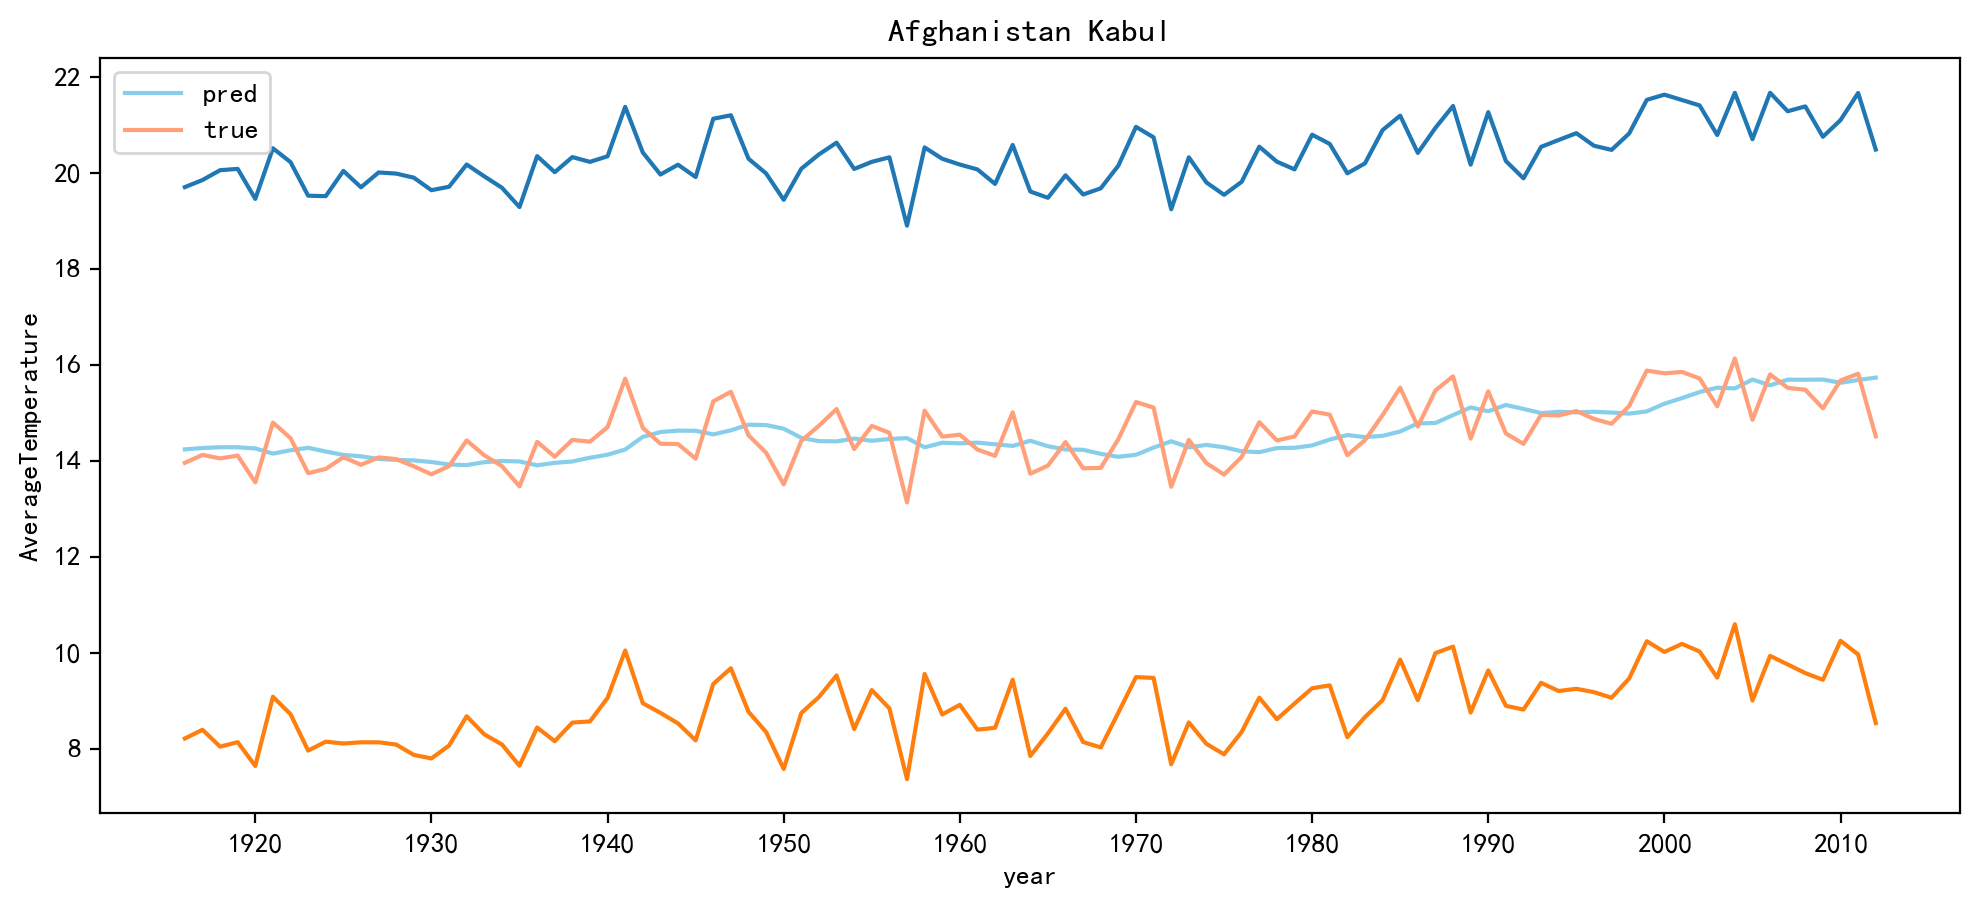

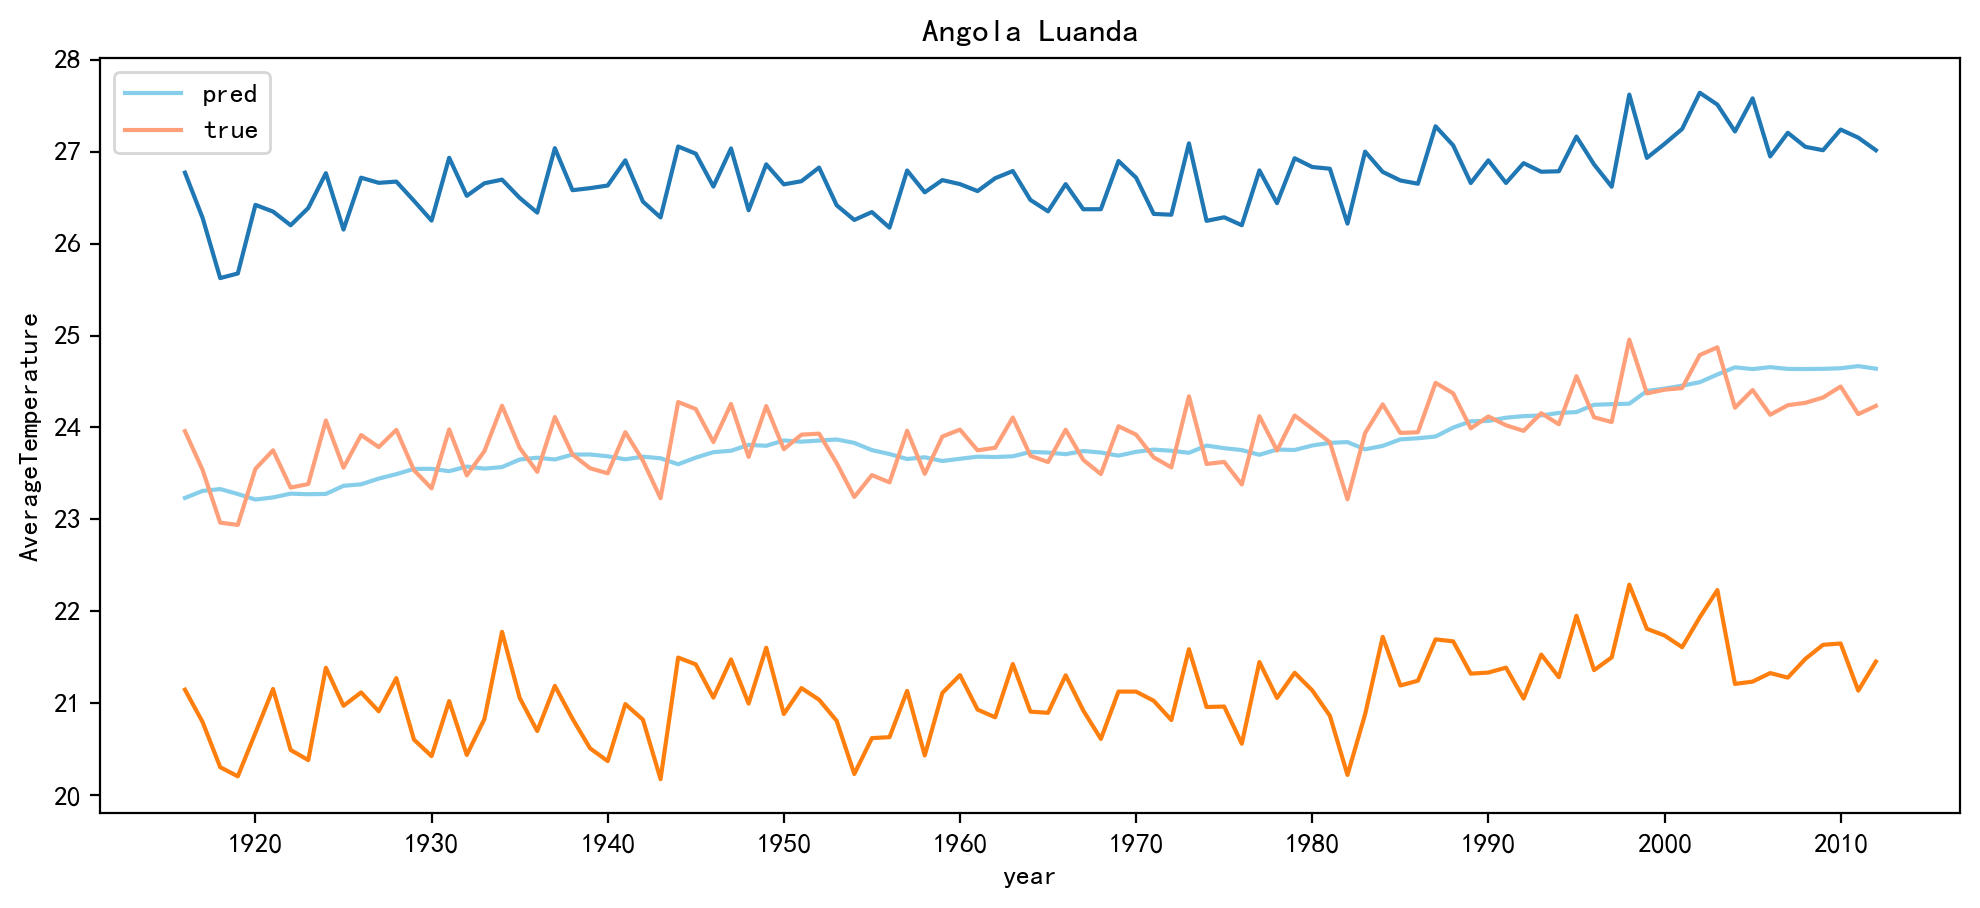

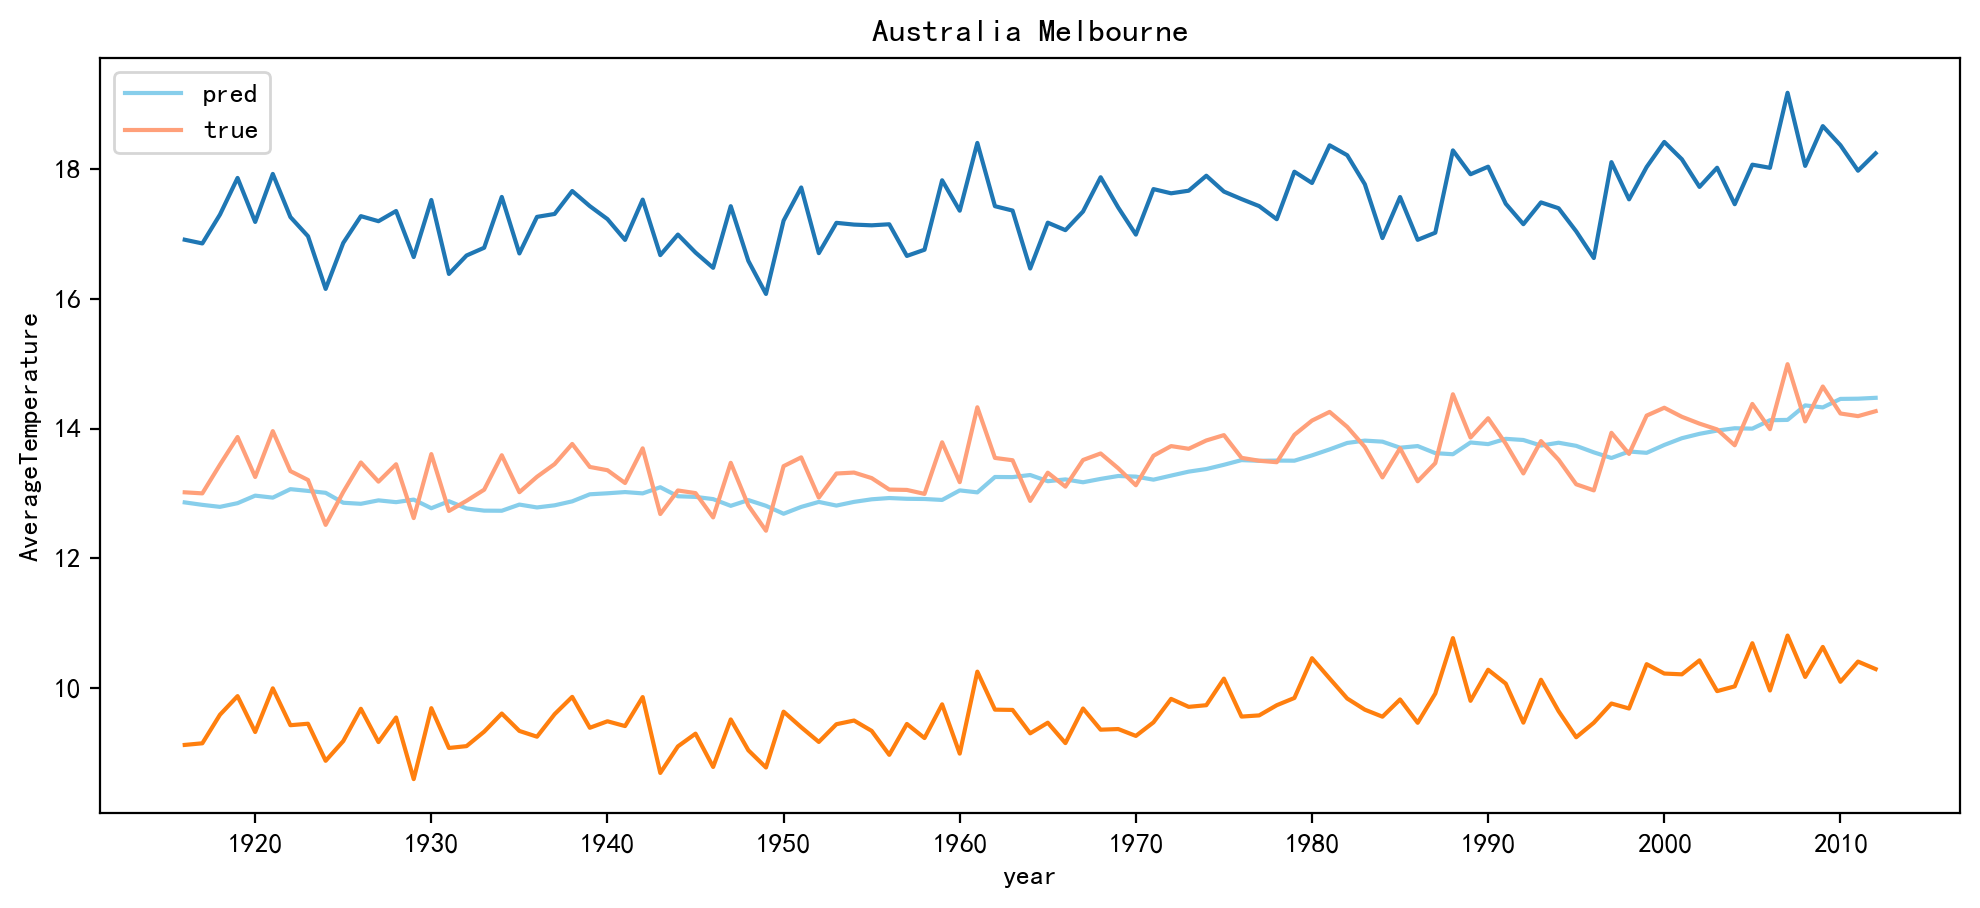

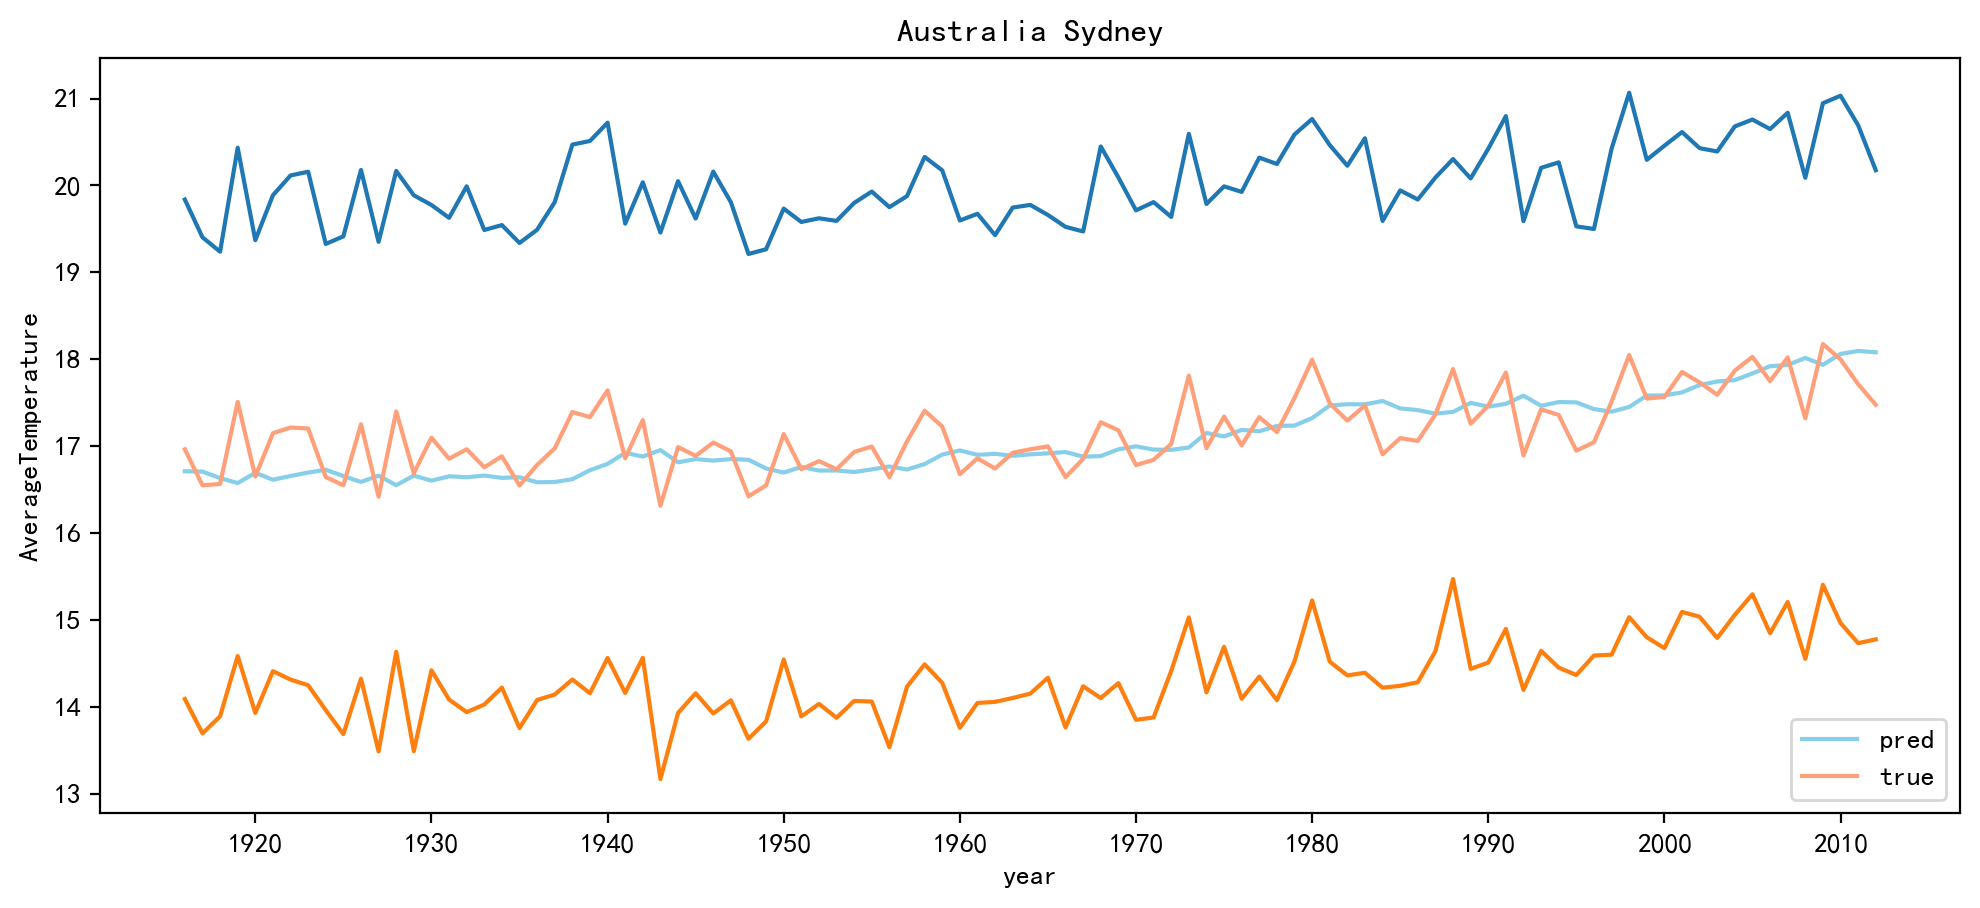

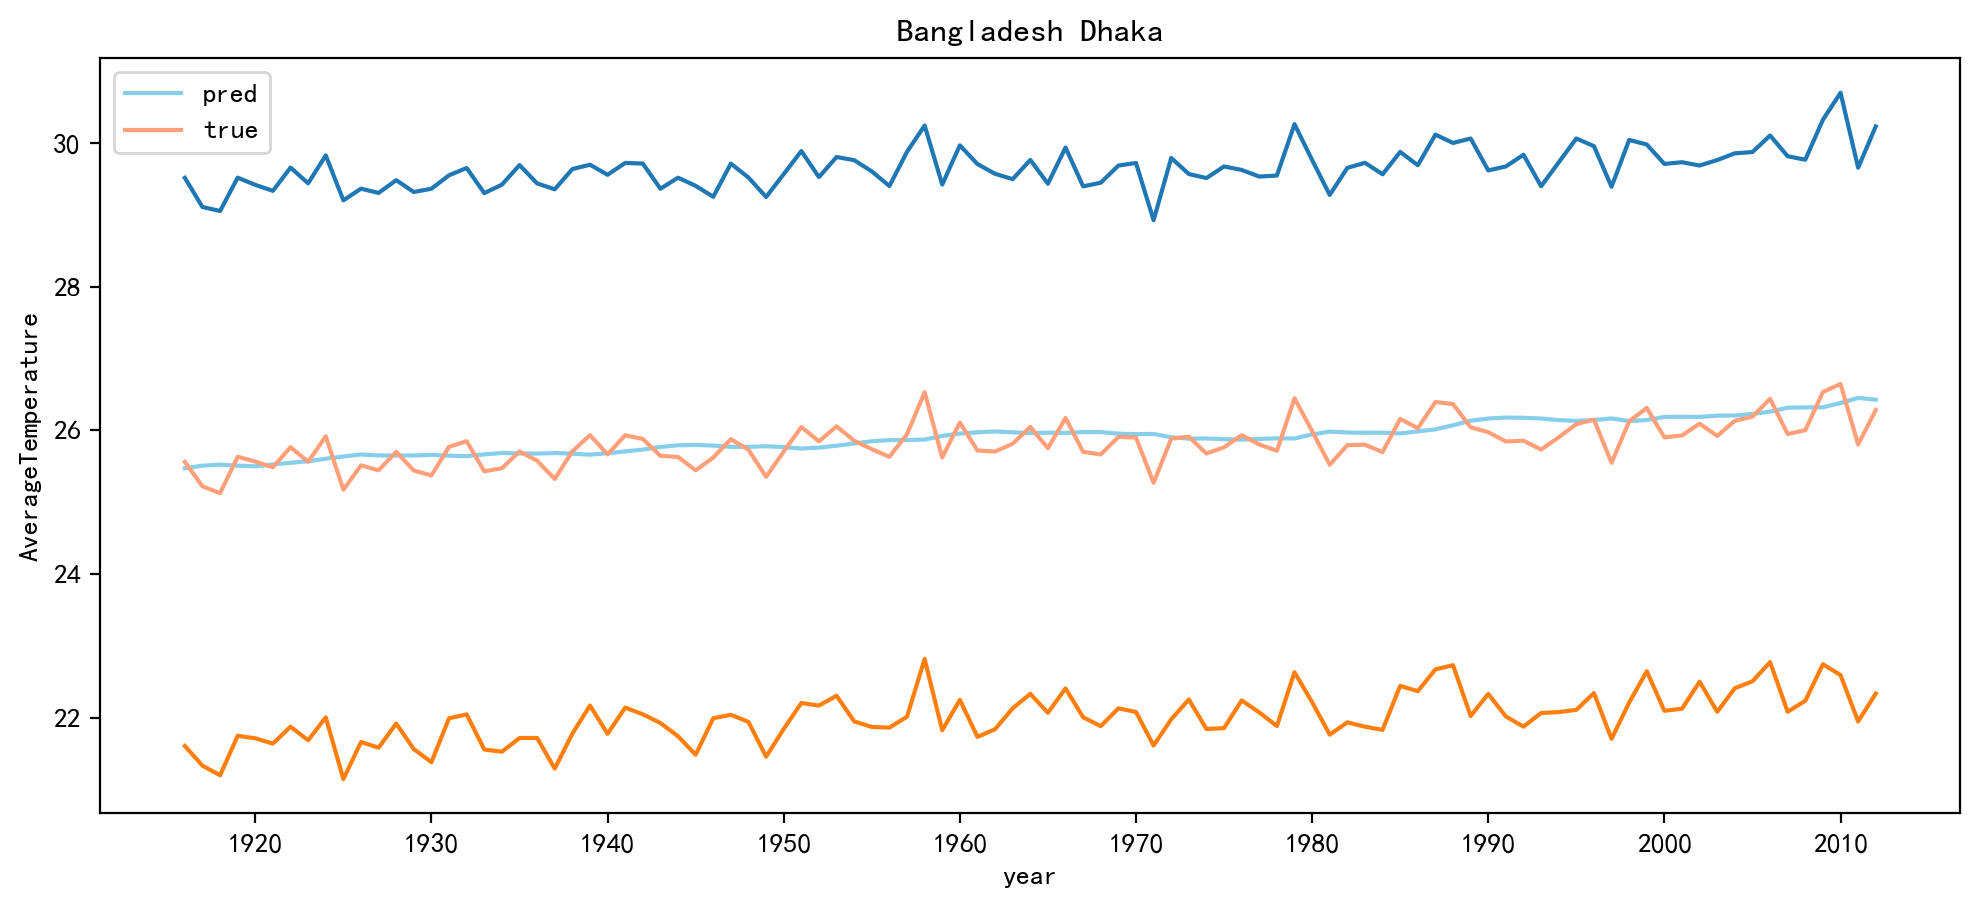

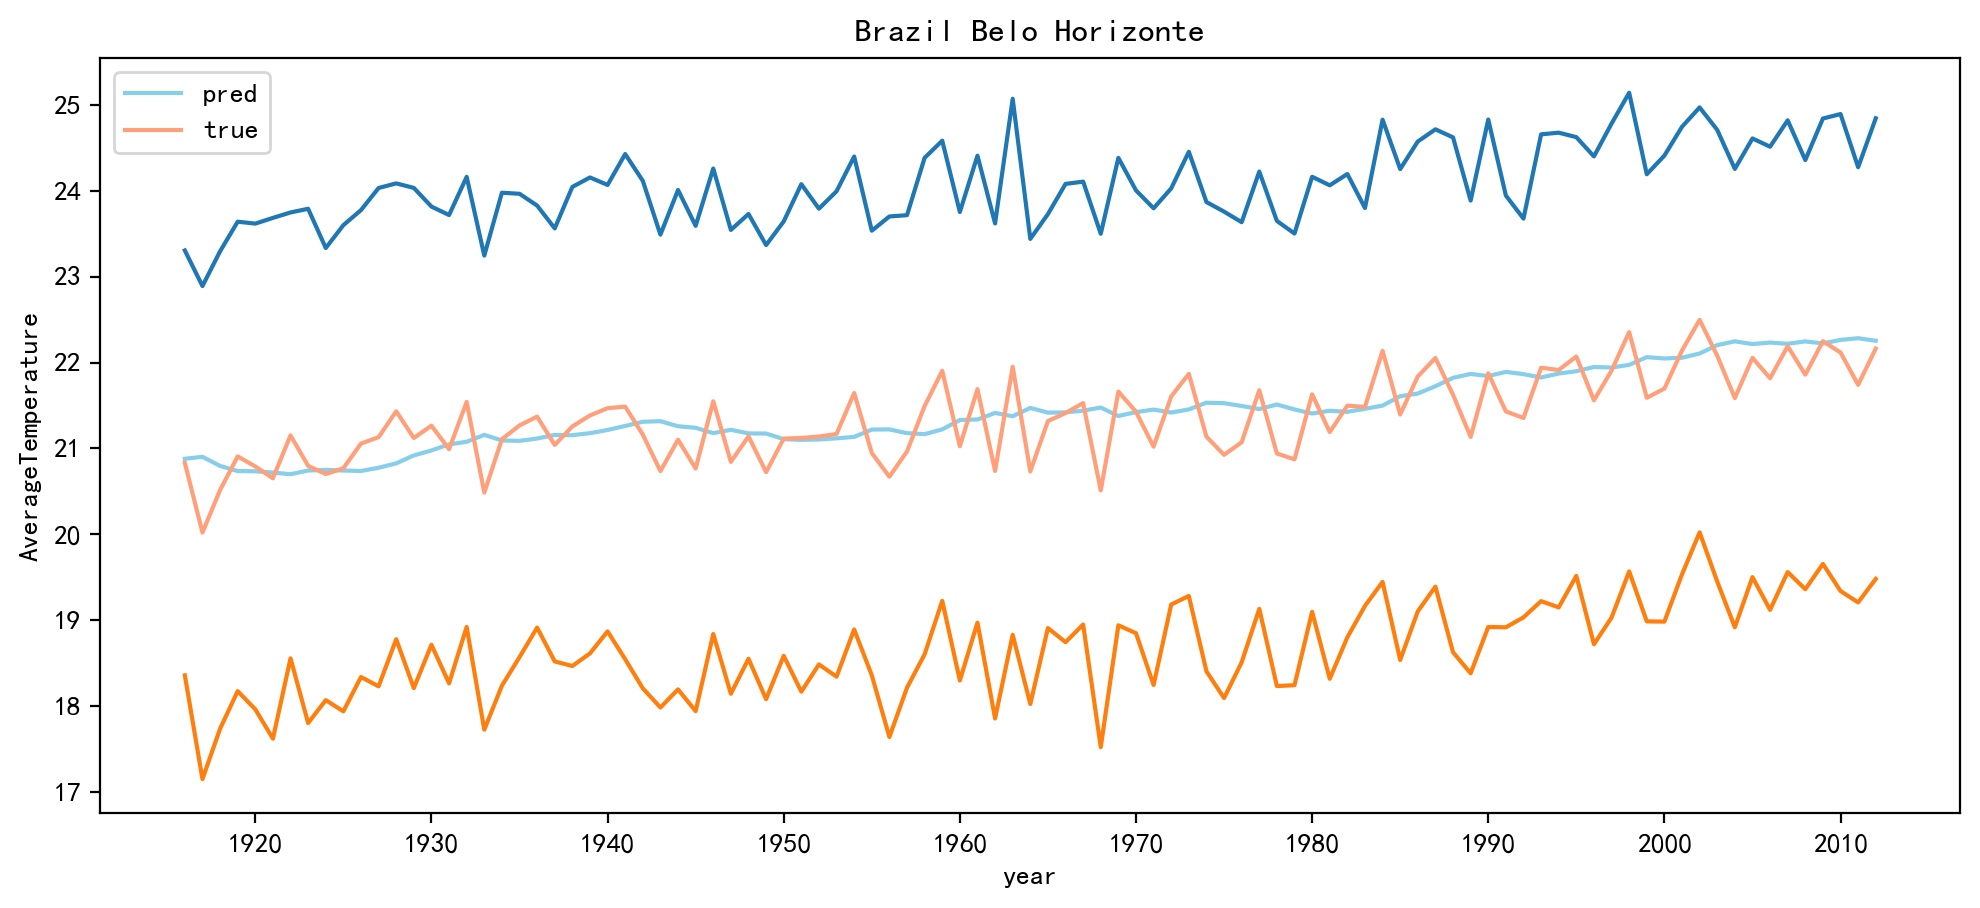

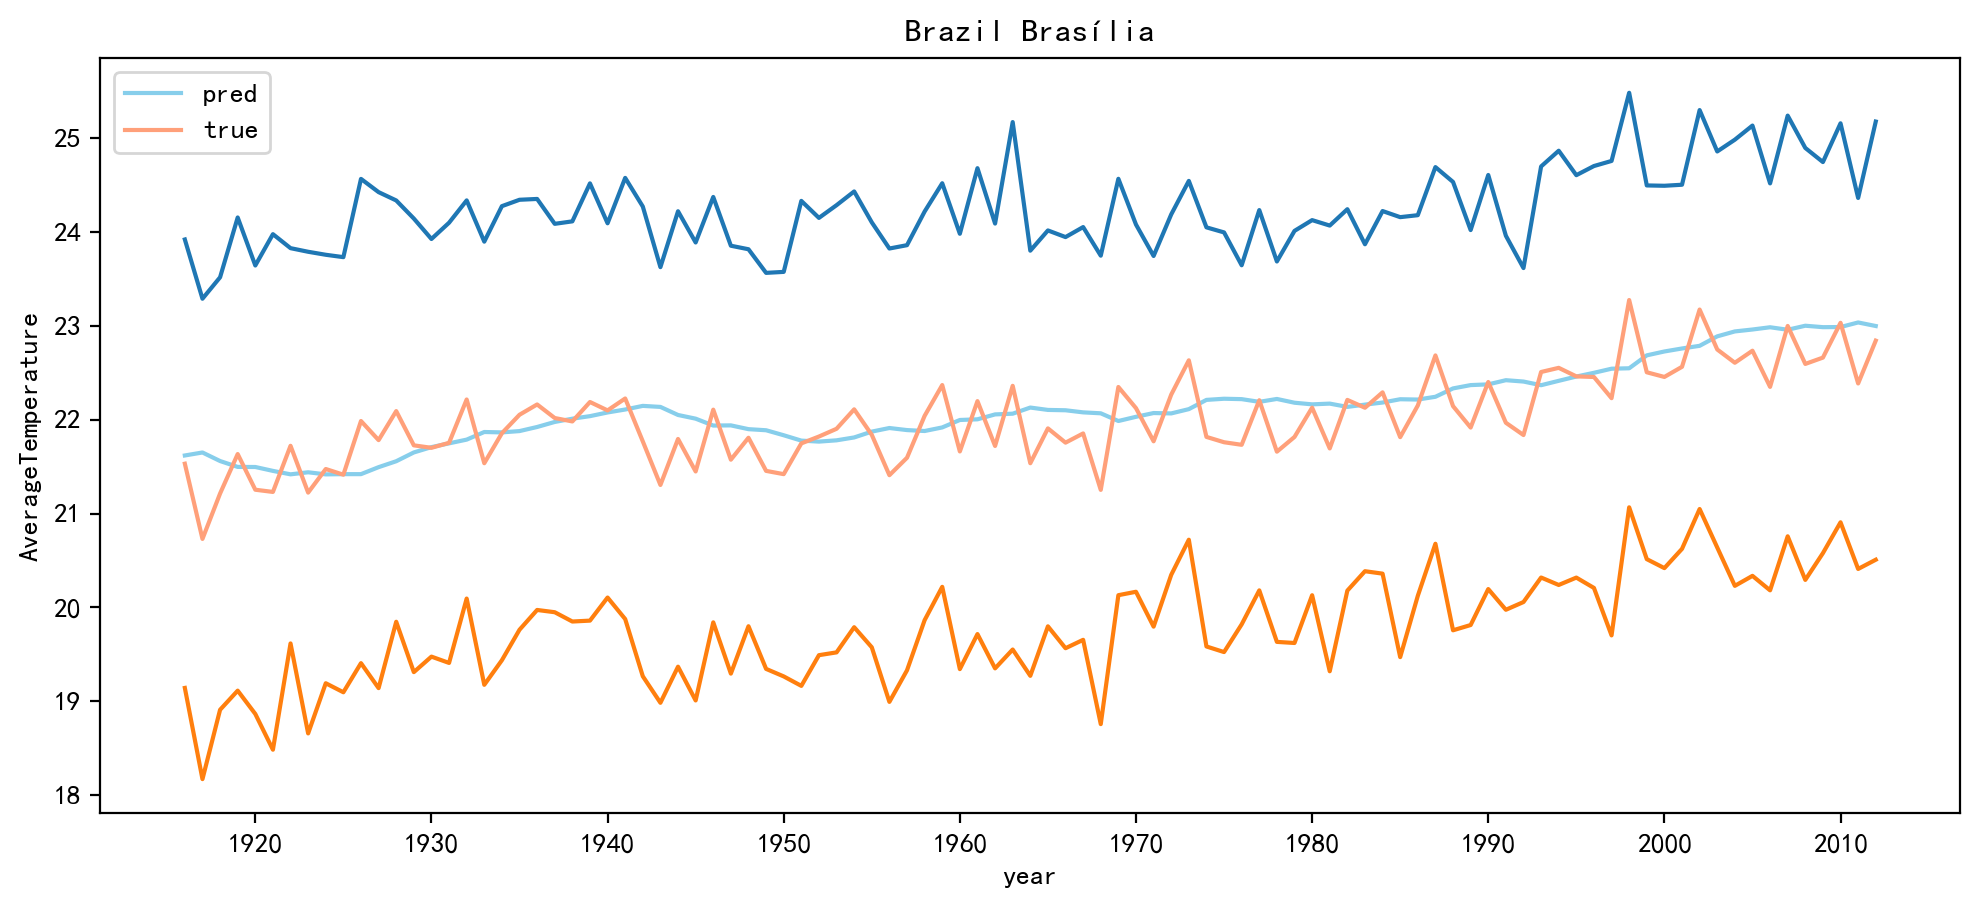

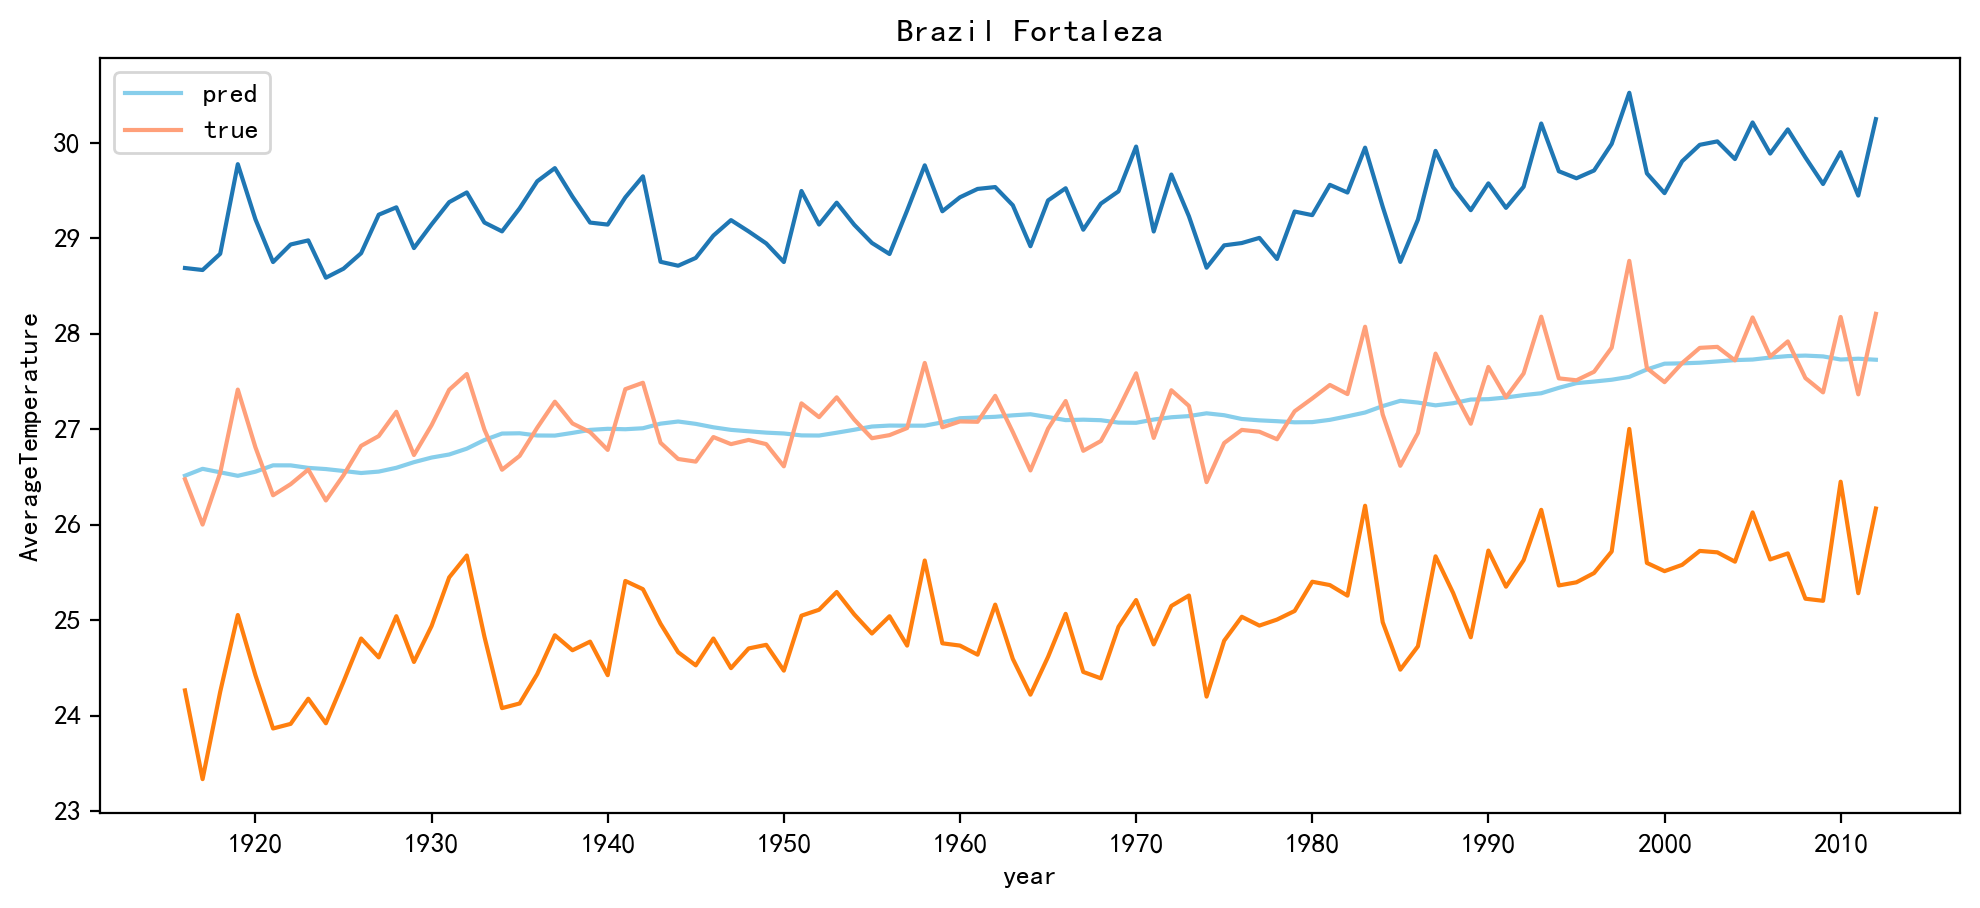

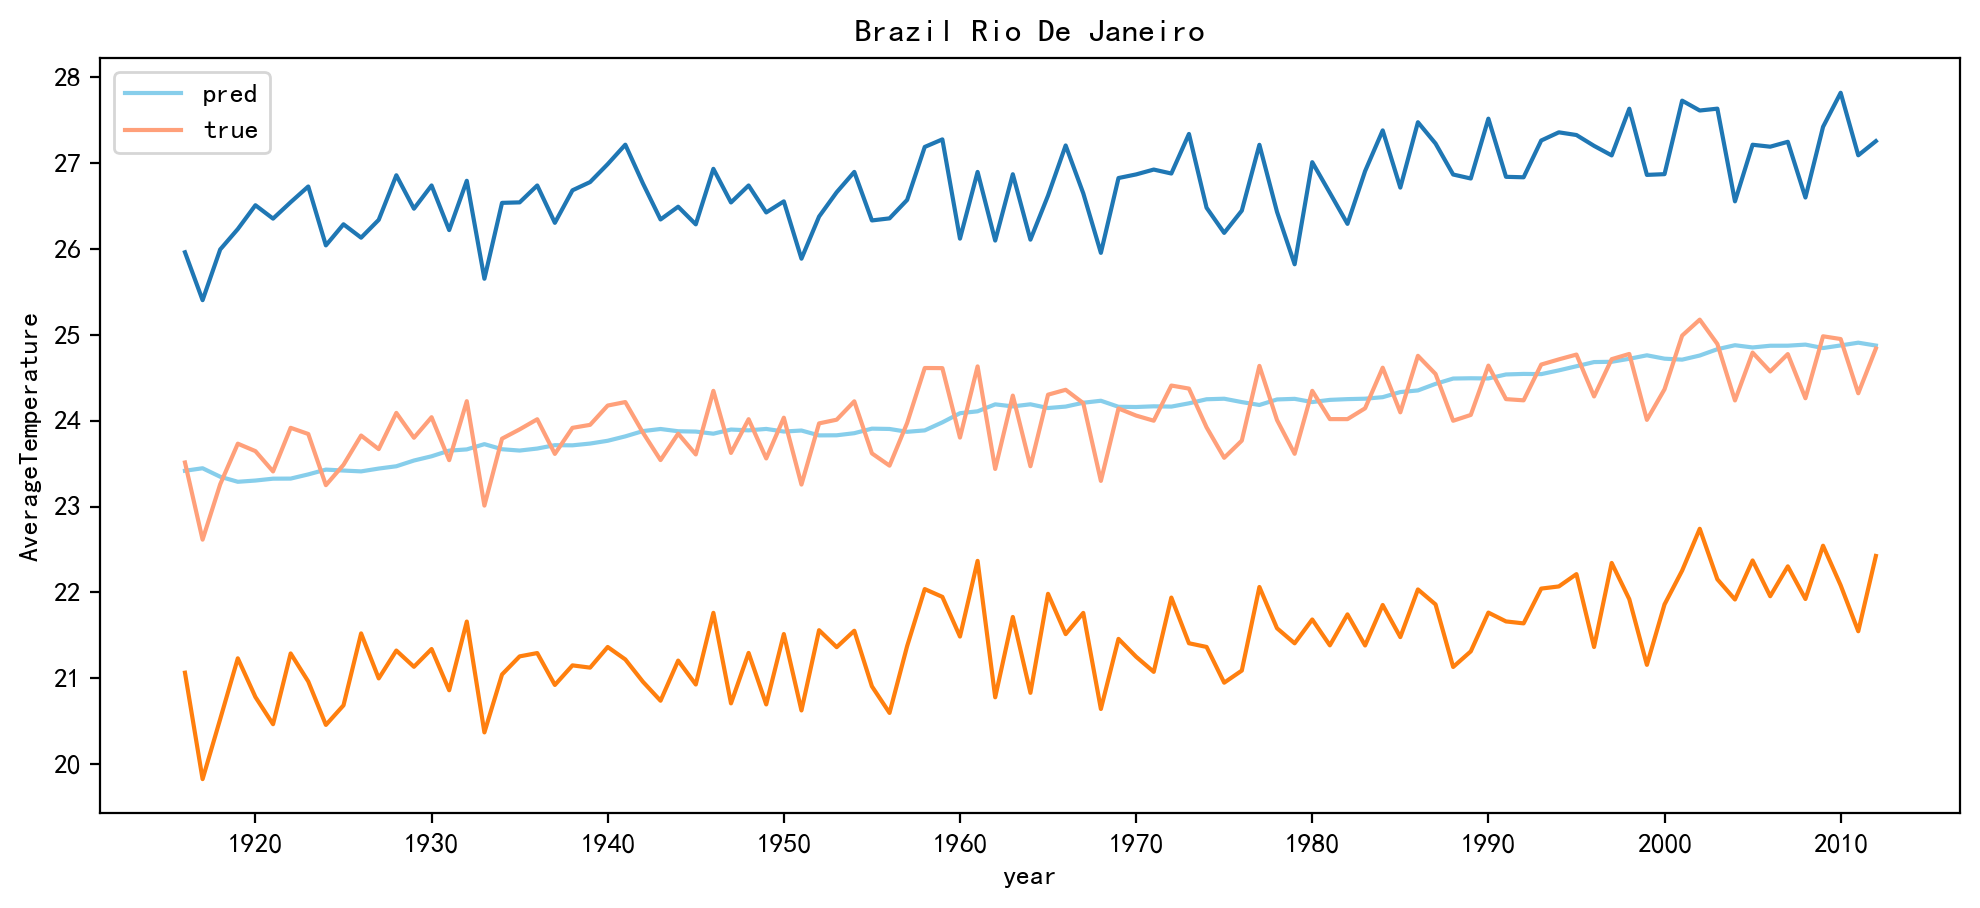

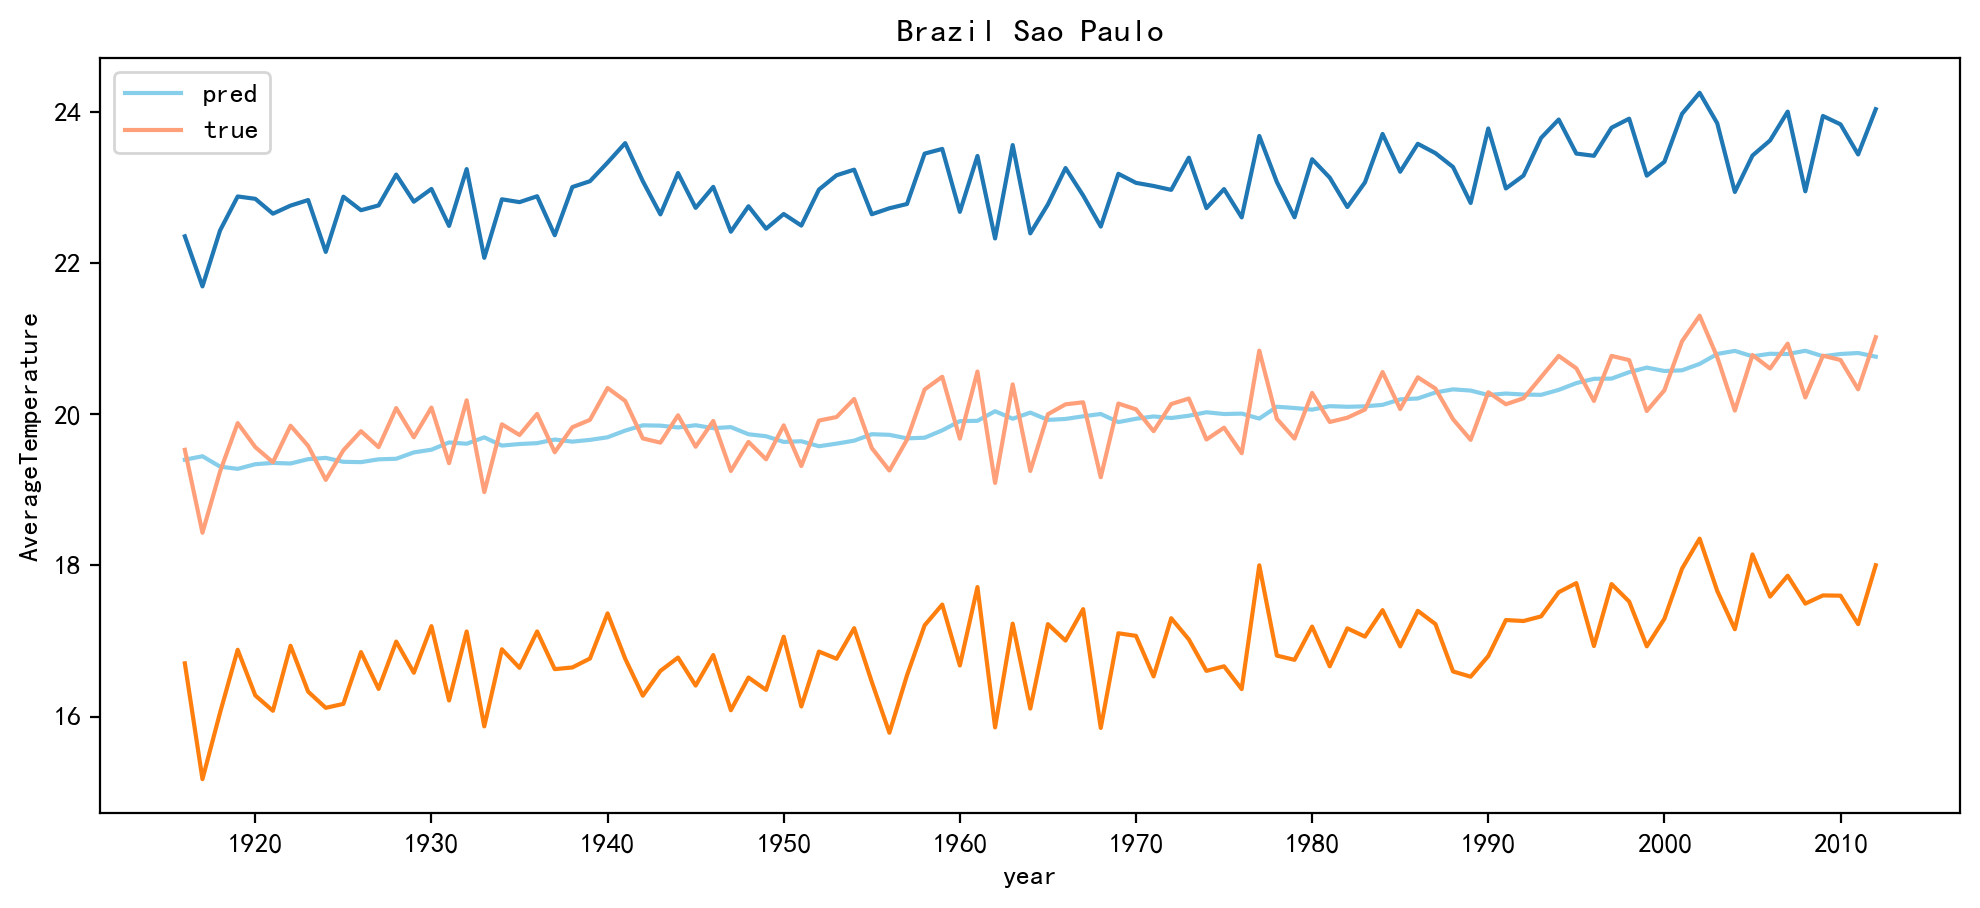

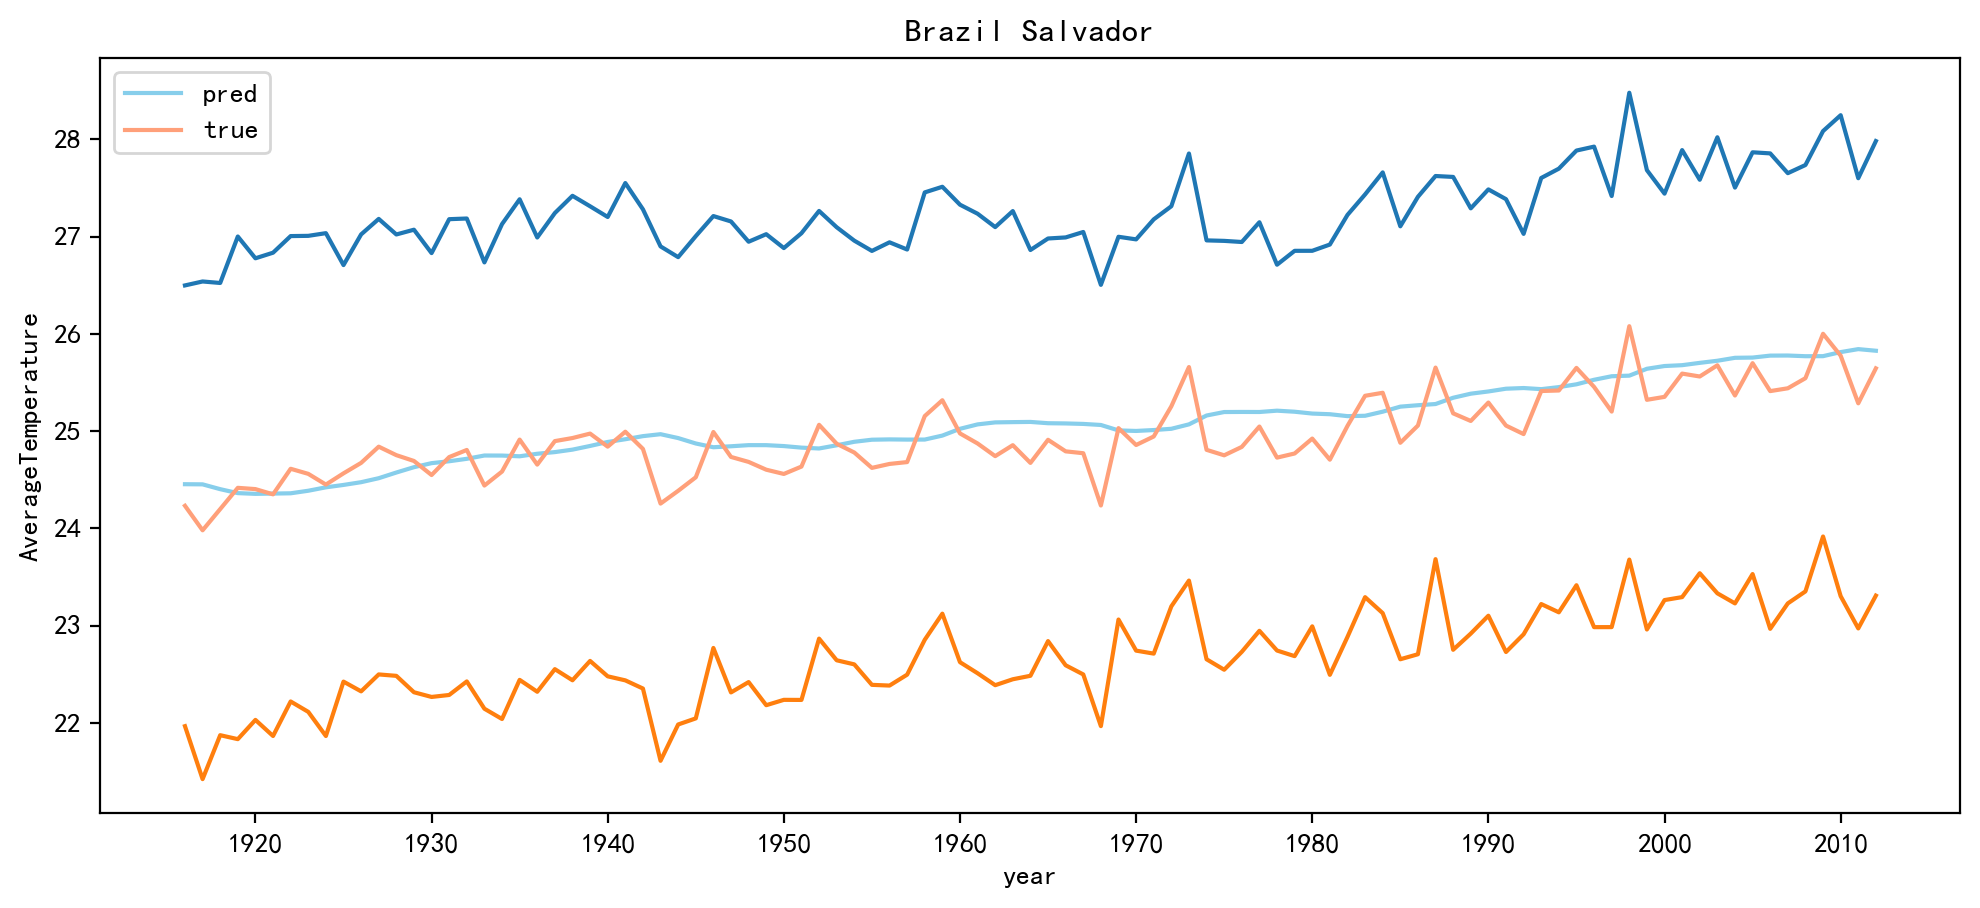

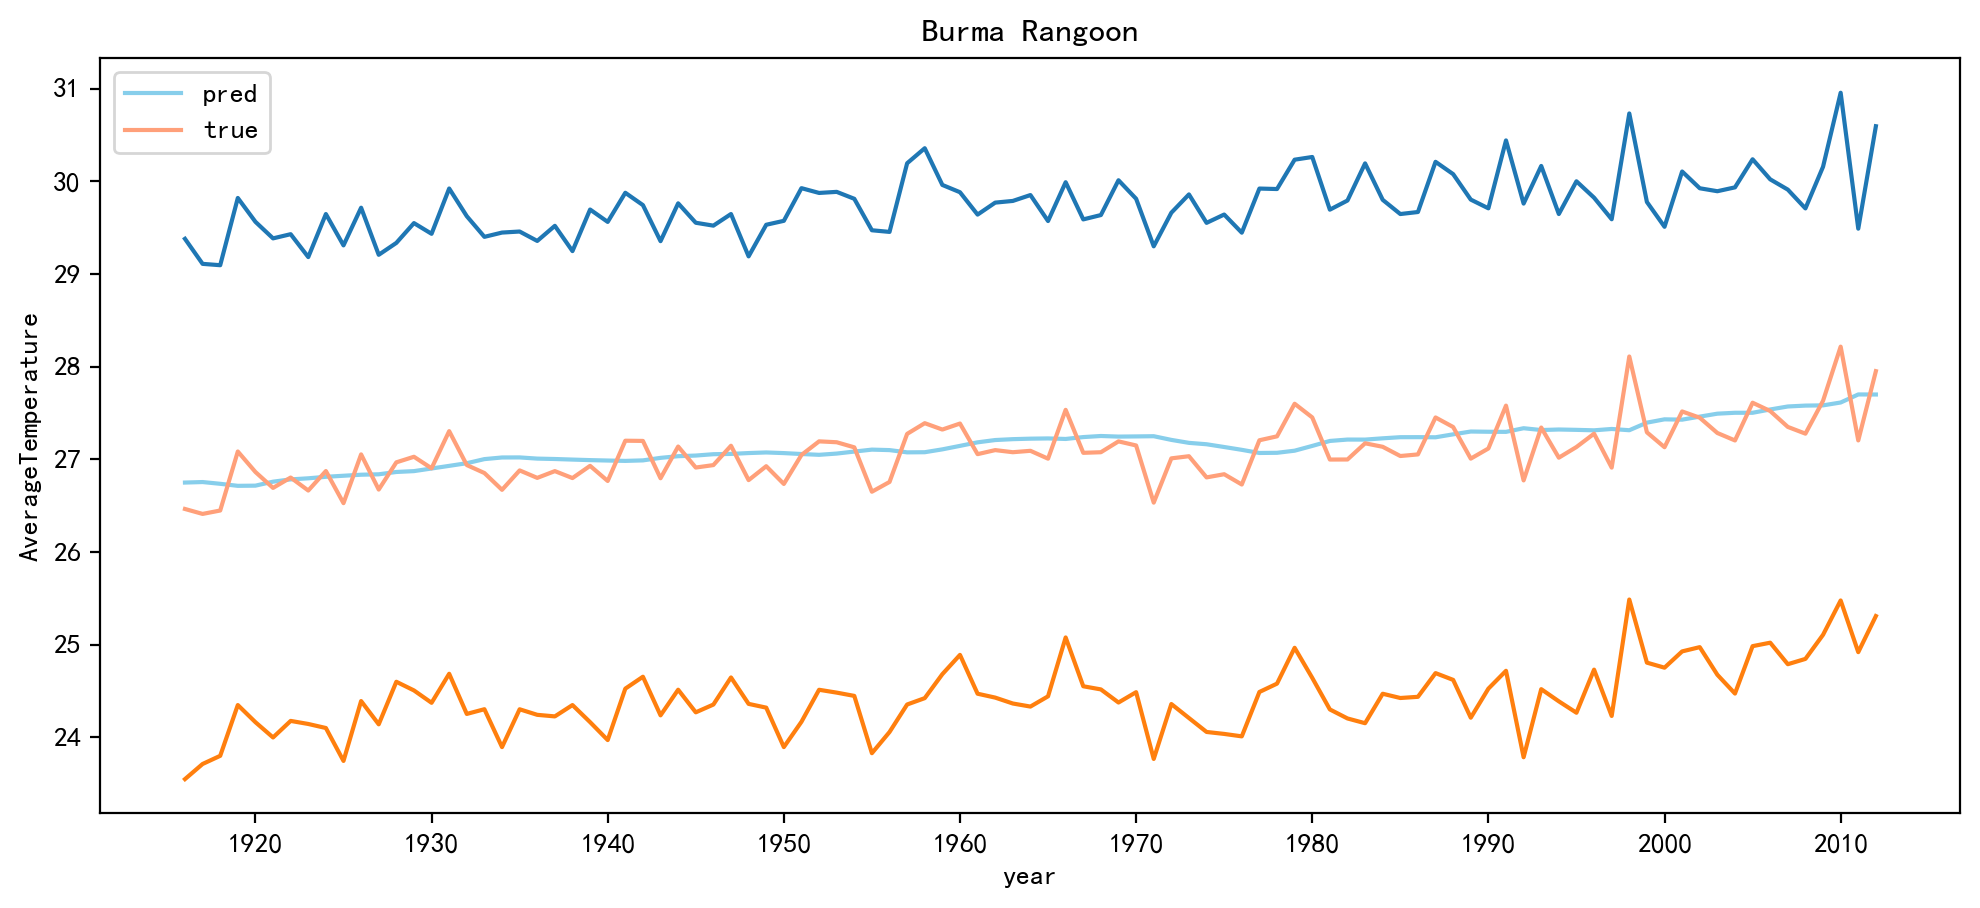

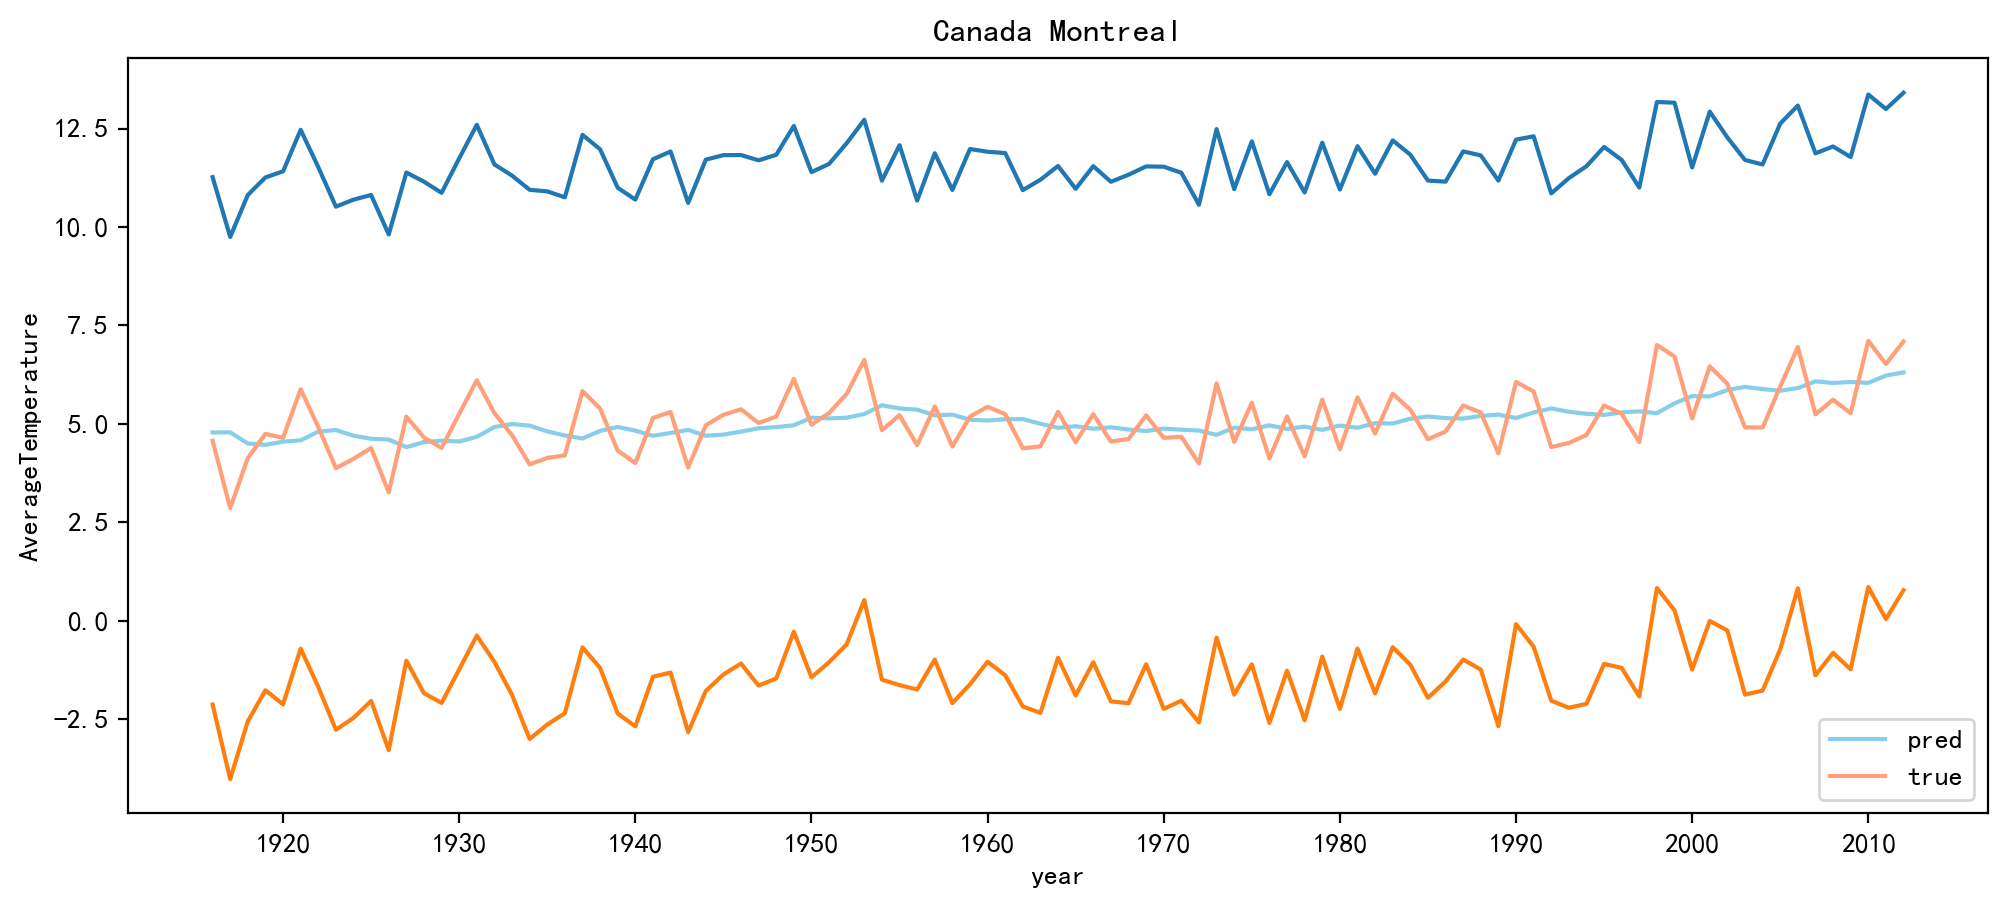

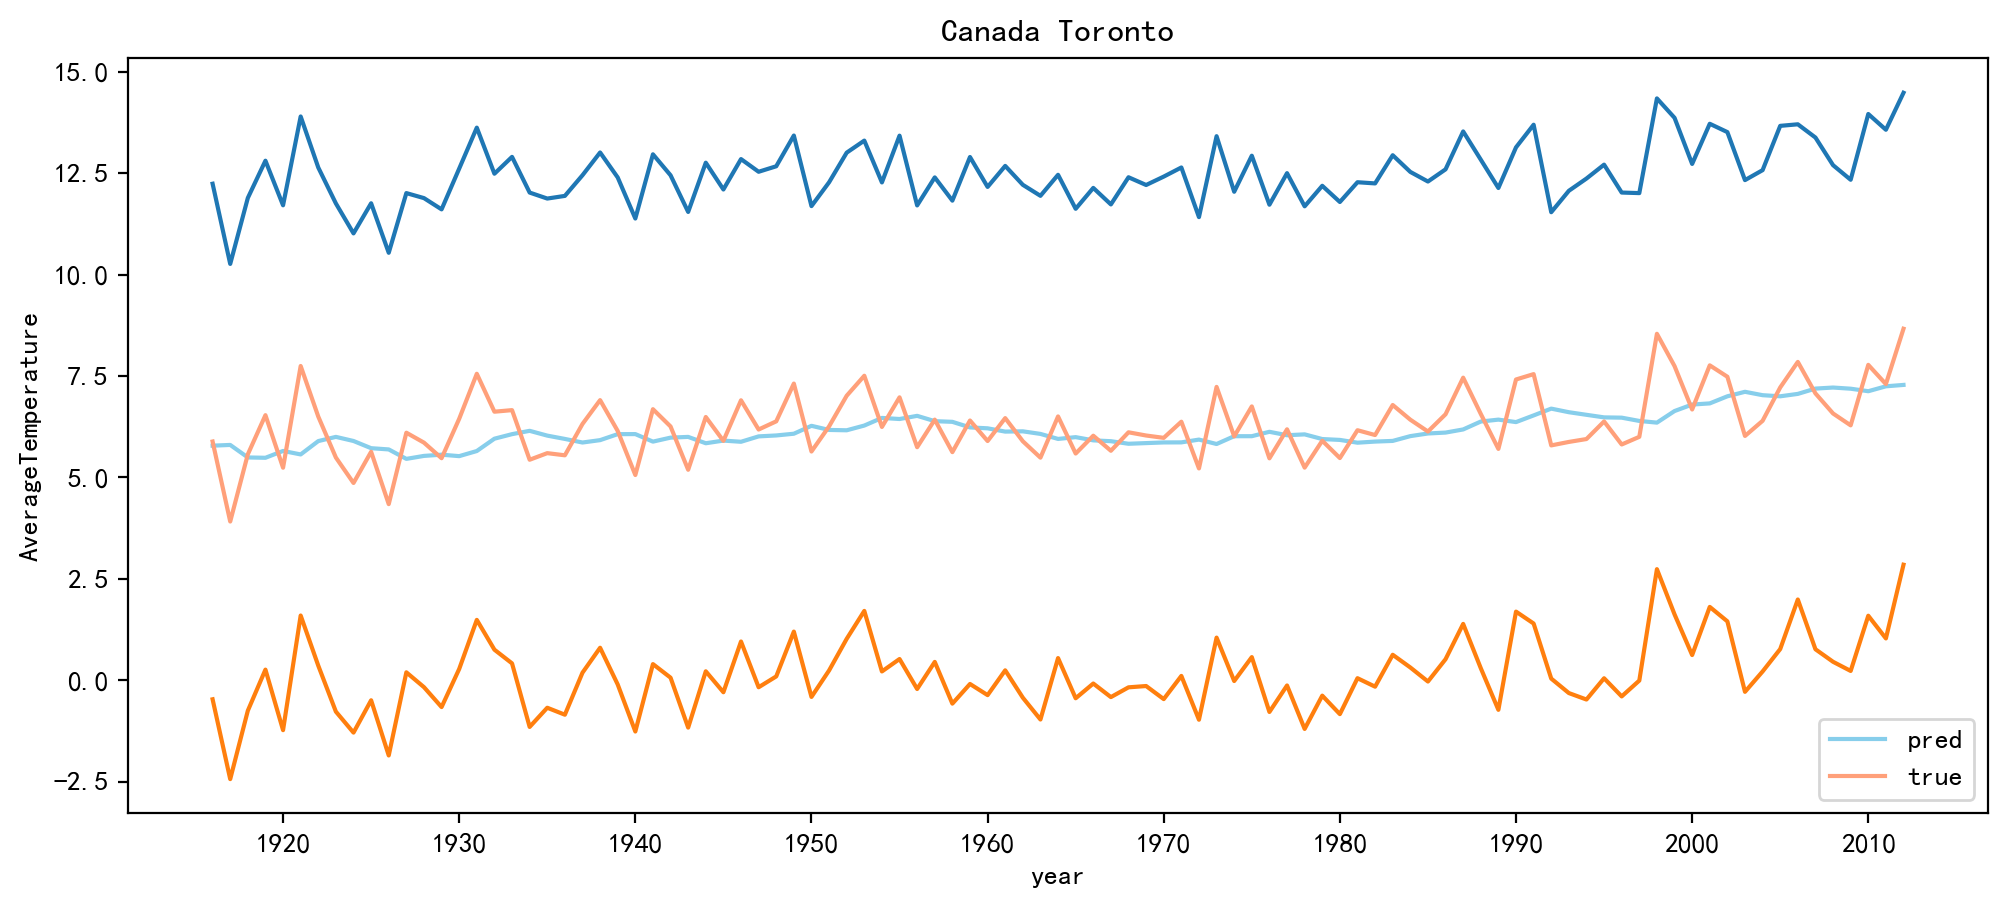

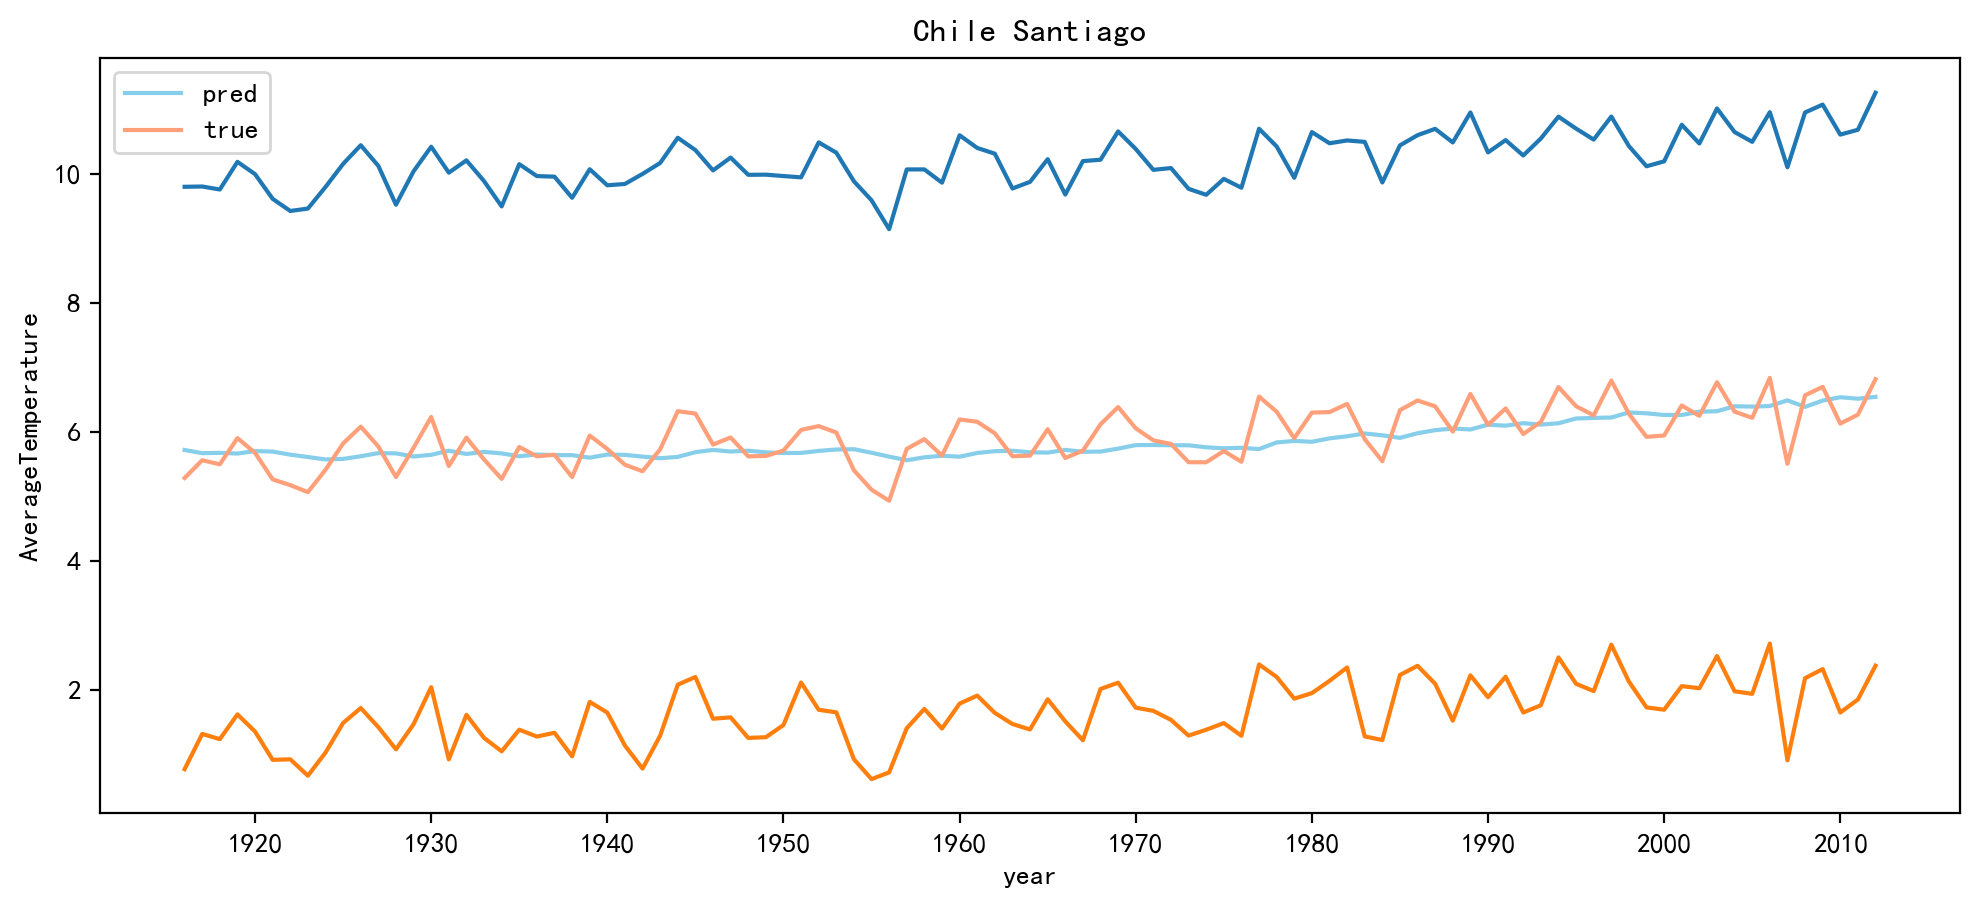

KeyboardInterrupt: 

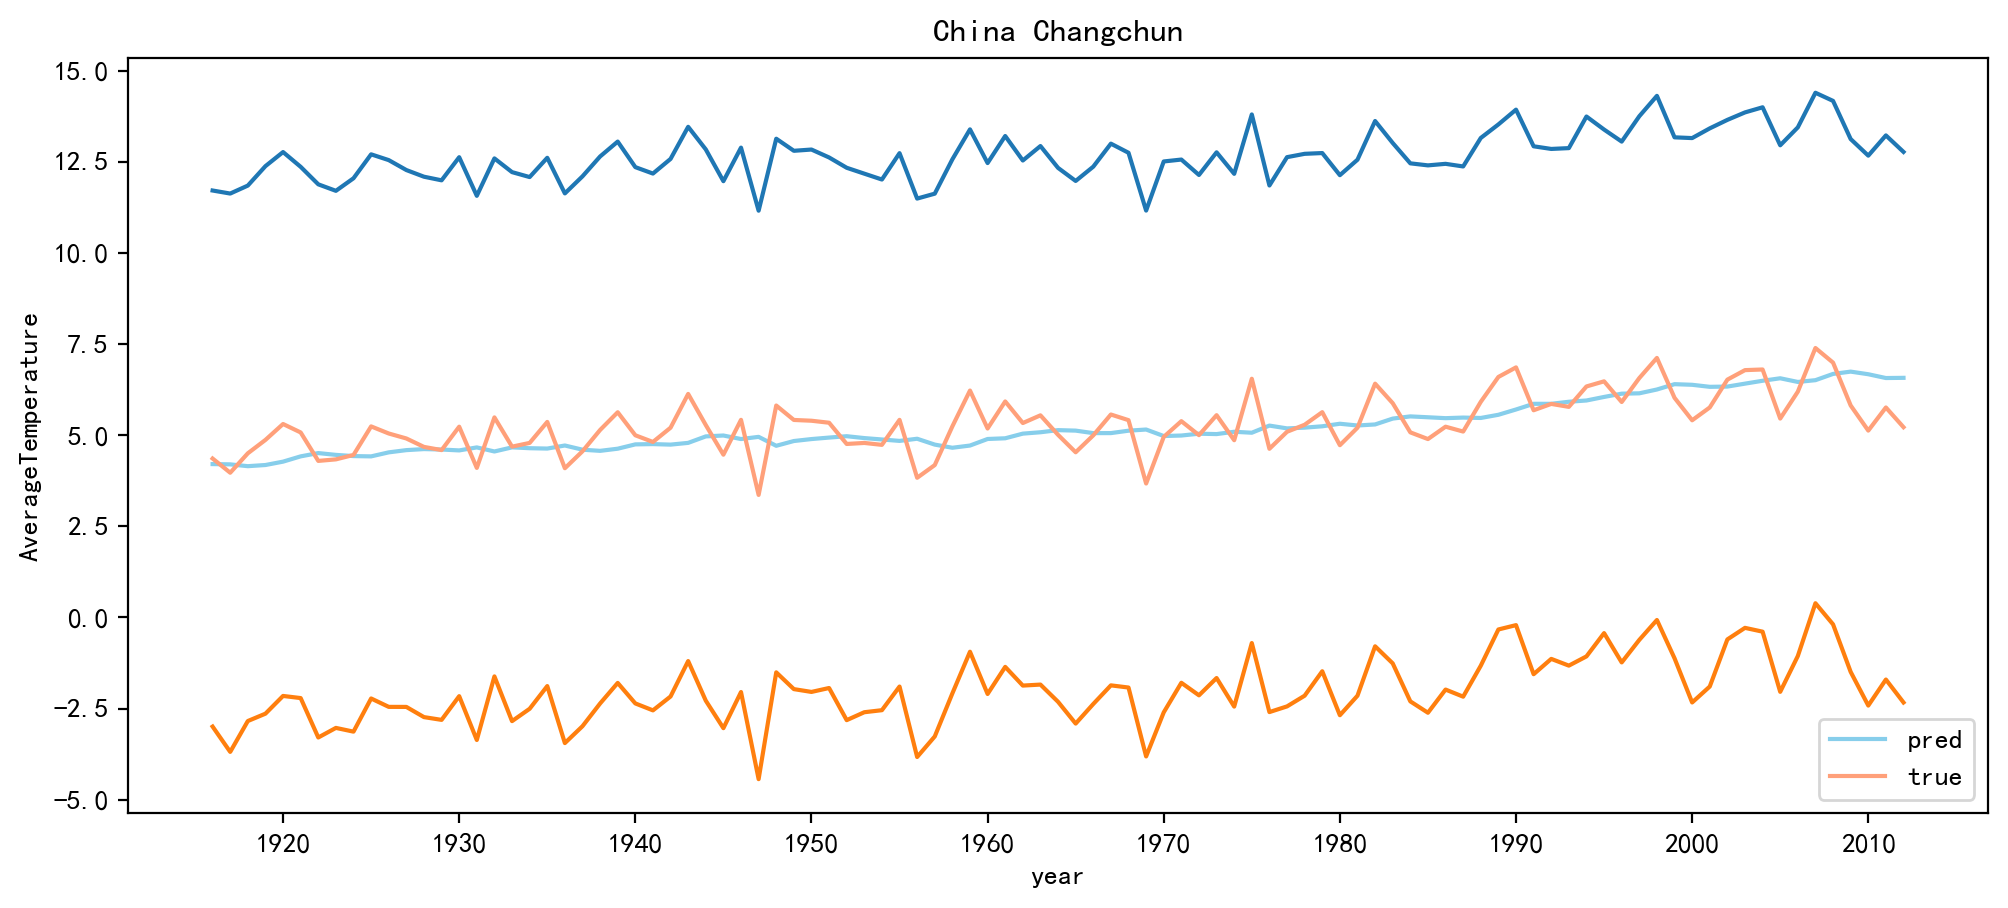

In [26]:
y_pred = model.predict(X_train).flatten()
step = int(X_train.shape[0] / 100)
for i in range(100):
    plt.figure(figsize=(12, 5), dpi=200)
    plt.title(df_year['location'].unique()[i])
    plt.xlabel('year')
    plt.ylabel('AverageTemperature')
    plt.plot(scaler_temperature.inverse_transform(y_pred[i * step: (i + 1) * step].reshape(-1, 1).flatten()), label='pred', color='skyblue')
    plt.plot(scaler_temperature.inverse_transform(y_train[i * step: (i + 1) * step].reshape(-1, 1).flatten()), label='true', color='lightsalmon')
    plt.plot(df_plt[df_plt['location']==df_plt['location'].unique()[i]]['max'].loc[1916: ].values)
    plt.plot(df_plt[df_plt['location']==df_plt['location'].unique()[i]]['min'].loc[1916: ].values)
    plt.xticks([4, 14, 24, 34, 44, 54, 64, 74, 84, 94], ['1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010'])
    plt.legend()
    plt.savefig(f"./可视化/{df_year['location'].unique()[i]}.png")
    plt.show()